# Data Preprocessing

* Generate These Tables:
  * Merchant Order table
    * Detailed orders for each merchant
  * Merchant Product table
    * Asile, deparment for each product of each merchant
  * Time Series purchase, client table

In [1]:
import pandas as pd
from datetime import date, timedelta
import random
import numpy as np

## Understand Data

* Raw data is downloaded from
  * https://www.kaggle.com/c/instacart-market-basket-analysis/data
  * https://en.wikipedia.org/wiki/List_of_supermarket_chains_in_Canada

In [2]:
products_df = pd.read_csv('products.csv')
print(products_df.shape)

products_df.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
departments_df = pd.read_csv('departments.csv')
print(departments_df.shape)

departments_df.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
aisles_df = pd.read_csv('aisles.csv')
print(aisles_df.shape)

aisles_df.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
# order_dow is the day of the week
orders_df = pd.read_csv('orders.csv')
print(orders_df.shape)

orders_df.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
order_prior_df = pd.read_csv('order_products__prior.csv')
print(order_prior_df.shape)

order_prior_df.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_train_df = pd.read_csv('order_products__train.csv')
print(order_train_df.shape)

order_train_df.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Utils

In [8]:
def get_monday_lst(year):
    d = date(year, 2, 17)    
    d += timedelta(days = 0 - d.weekday())  # First Monday
    while d.year == year and d.month < 5:
        yield d
        d += timedelta(days = 7)

        
def uniform_random_select(lst, const):
    rand = random.randint(0, const%len(lst))
    return lst[rand]


#  Assign a purchase date to each order
monday_seeds = list(get_monday_lst(2020))
user_startingdate_dct = {}
def assign_date(r):
    user_id = r[1]
    days_since_prior_order = r[2]
    order_dow = r[3]
    
    if np.isnan(days_since_prior_order):
        row_date = uniform_random_select(monday_seeds, user_id) + timedelta(days = order_dow)
        user_startingdate_dct[user_id] = row_date
    else:
        row_date = user_startingdate_dct[user_id] + timedelta(days = days_since_prior_order)
        
    r = r.append(row_date)

## Merchant Order Table

In [9]:
# unit both prior and train orders
order_prior_train_df = order_prior_df.append(order_train_df)
print(order_prior_train_df.shape)

(33819106, 4)


In [10]:
order_prod_df = orders_df.merge(order_prior_train_df, on='order_id')
order_prod_df = order_prod_df.sort_values(by=['user_id', 'order_number'])
print(order_prod_df.shape)

order_prod_df.head()

(33819106, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


### Add purchase_date

* For each order in each user, assign a random date but in time order listed in "days_since_prior_order".
* Random number is uniform distribution.

In [135]:
user_group_df = order_prod_df[['order_id', 'user_id', 'days_since_prior_order', 'order_dow', 'order_number']].drop_duplicates()
user_group_df = user_group_df.sort_values(by=['user_id', 'order_number'])

print(user_group_df.shape)

user_group_df.head()

(3346083, 5)


,order_id,user_id,days_since_prior_order,order_dow,order_number
0,2539329,1,NaN,2,1
5,2398795,1,15.0,3,2
11,473747,1,21.0,3,3
16,2254736,1,29.0,4,4
21,431534,1,28.0,4,5


In [124]:
# Using a list is faster
user_group_records = user_group_df.values.tolist()

for r in user_group_records:
    assign_date(r)
    
print (user_group_records[0:4])

[[2539329.0, 1.0, nan, 2.0, 1.0, datetime.date(2020, 2, 26)], [2398795.0, 1.0, 15.0, 3.0, 2.0, datetime.date(2020, 3, 12)], [473747.0, 1.0, 21.0, 3.0, 3.0, datetime.date(2020, 3, 18)], [2254736.0, 1.0, 29.0, 4.0, 4.0, datetime.date(2020, 3, 26)]]


In [125]:
user_group_df = pd.DataFrame(user_group_records)
user_group_df.columns = ['order_id', 'user_id', 'days_since_prior_order', 'order_dow', 'order_number', 'purchase_date']
user_group_df.head()

,order_id,user_id,days_since_prior_order,order_dow,order_number,purchase_date
0,2539329.0,1.0,NaN,2.0,1.0,2020-02-26
1,2398795.0,1.0,15.0,3.0,2.0,2020-03-12
2,473747.0,1.0,21.0,3.0,3.0,2020-03-18
3,2254736.0,1.0,29.0,4.0,4.0,2020-03-26
4,431534.0,1.0,28.0,4.0,5.0,2020-03-25


In [127]:
order_prod_df = order_prod_df.merge(user_group_df[['order_id', 'purchase_date']], on='order_id')
print(order_prod_df.shape)

order_prod_df.head()

(33819106, 11)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,purchase_date
0,2539329,1,prior,1,2,8,NaN,196,1,0,2020-02-26
1,2539329,1,prior,1,2,8,NaN,14084,2,0,2020-02-26
2,2539329,1,prior,1,2,8,NaN,12427,3,0,2020-02-26
3,2539329,1,prior,1,2,8,NaN,26088,4,0,2020-02-26
4,2539329,1,prior,1,2,8,NaN,26405,5,0,2020-02-26


### Add merchant

* Randomly assign merchant for each order_id.
* Random number is in normal distribution.

In [139]:
merchant_lst = ["49th Parallel Grocery", "Asian Food Centre", "Askew's Foods", "Avril (Health Supermarket)", "Coleman's",
                "Co-op Atlantic", "Valu Foods", "Village Food Stores", "Coppa's Fresh Market", "Country Grocer",
                "Fairway Markets", "Family Foods", "Calgary Co-op", "North Central Co-op", "Red River Co-op",
                "Saskatoon Co-op", "Foodex", "FoodFare", "Fresh City Market", "Freson Bros.", "Galleria Supermarkets",
                "Goodness me", "H Mart", "Highland Farms", "Kim Phat", "Le Jardin Mobile", "L&M Markets (Hometown Grocers Co-op)",
                "Lalumière Bonanza", "Longo's", "Marché Frais", "Le Marché Esposito", "Les Arpents Verts", "Lococo's",
                "Lucky Supermarket", "Mike Dean's Super Food Stores", "Nations Fresh Food", "Nature's Emporium",
                "Northern", "NorthMart", "Panchvati Supermarket", "P.A.T. Mart", "Planet Organic", "Pomme Natural Market",
                "Rabba Fine Foods", "Subzi Mandi Cash & Carry", "Quality Foods", "Sunterra Market", "TaiKo Supermarket",
                "Vince's Market"]
len(merchant_lst)

49

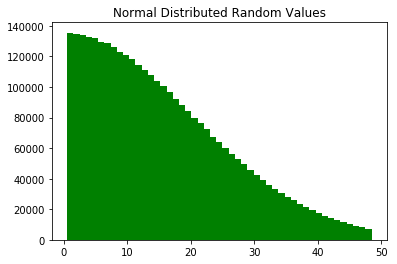

In [162]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.5, len(merchant_lst))
xU, xL = x + 0.5, x - 0.5 
prob = ss.norm.cdf(xU, scale = 20) - ss.norm.cdf(xL, scale = 20)
prob = prob / prob.sum() #normalize the probabilities so their sum is 1
nums = np.random.choice(x, size = order_prod_df['order_id'].nunique(), p = prob)
plt.hist(nums, bins = len(x), color='g')
plt.title('Normal Distributed Random Values')
plt.show()

In [163]:
print(int(min(nums)), int(max(nums)))

0 48


In [164]:
# order_id list
orderid_lst = order_prod_df['order_id'].unique()

order_merchant_records = []
for i in range(len(orderid_lst)):
    orderid = orderid_lst[i]
    merchant = merchant_lst[int(nums[i])]
    order_merchant_records.append([orderid, merchant])
    
order_merchant_df = pd.DataFrame(order_merchant_records)
order_merchant_df.columns = ['order_id', 'merchant']
order_merchant_df.head()

,order_id,merchant
0,2539329,Foodex
1,2398795,Highland Farms
2,473747,Coppa's Fresh Market
3,2254736,Fresh City Market
4,431534,Mike Dean's Super Food Stores


In [167]:
order_prod_df = order_prod_df.merge(order_merchant_df, on='order_id')
print(order_prod_df.shape)
order_prod_df.head()

(33819106, 12)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,purchase_date,merchant
0,2539329,1,prior,1,2,8,NaN,196,1,0,2020-02-26,Foodex
1,2539329,1,prior,1,2,8,NaN,14084,2,0,2020-02-26,Foodex
2,2539329,1,prior,1,2,8,NaN,12427,3,0,2020-02-26,Foodex
3,2539329,1,prior,1,2,8,NaN,26088,4,0,2020-02-26,Foodex
4,2539329,1,prior,1,2,8,NaN,26405,5,0,2020-02-26,Foodex


In [170]:
order_prod_df.drop(['eval_set', 'order_dow', 'days_since_prior_order', 'reordered', 'add_to_cart_order'], 
                   inplace=True, axis=1)
order_prod_df.head()

,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant
0,2539329,1,1,8,196,2020-02-26,Foodex
1,2539329,1,1,8,14084,2020-02-26,Foodex
2,2539329,1,1,8,12427,2020-02-26,Foodex
3,2539329,1,1,8,26088,2020-02-26,Foodex
4,2539329,1,1,8,26405,2020-02-26,Foodex


In [172]:
order_prod_df.to_pickle('merchant_order.pkl')

## Merchant Product Table

In [56]:
merchant_prod = order_prod_df[['merchant', 'product_id']].drop_duplicates()
print(merchant_prod.shape)
merchant_prod.head()

(1440825, 2)


,merchant,product_id
0,Foodex,196
1,Foodex,14084
2,Foodex,12427
3,Foodex,26088
4,Foodex,26405


In [57]:
merchant_prod_df = merchant_prod.merge(products_df, on='product_id')
print(merchant_prod_df.shape)
merchant_prod_df.head()

(1440825, 5)


,merchant,product_id,product_name,aisle_id,department_id
0,Foodex,196,Soda,77,7
1,Highland Farms,196,Soda,77,7
2,Coppa's Fresh Market,196,Soda,77,7
3,Fresh City Market,196,Soda,77,7
4,Mike Dean's Super Food Stores,196,Soda,77,7


In [58]:
merchant_prod_df = merchant_prod_df.merge(aisles_df, on='aisle_id')
print(merchant_prod_df.shape)
merchant_prod_df.head()

(1440825, 6)


,merchant,product_id,product_name,aisle_id,department_id,aisle
0,Foodex,196,Soda,77,7,soft drinks
1,Highland Farms,196,Soda,77,7,soft drinks
2,Coppa's Fresh Market,196,Soda,77,7,soft drinks
3,Fresh City Market,196,Soda,77,7,soft drinks
4,Mike Dean's Super Food Stores,196,Soda,77,7,soft drinks


In [59]:
merchant_prod_df = merchant_prod_df.merge(departments_df, on='department_id')
print(merchant_prod_df.shape)
merchant_prod_df.head()

(1440825, 7)


,merchant,product_id,product_name,aisle_id,department_id,aisle,department
0,Foodex,196,Soda,77,7,soft drinks,beverages
1,Highland Farms,196,Soda,77,7,soft drinks,beverages
2,Coppa's Fresh Market,196,Soda,77,7,soft drinks,beverages
3,Fresh City Market,196,Soda,77,7,soft drinks,beverages
4,Mike Dean's Super Food Stores,196,Soda,77,7,soft drinks,beverages


In [26]:
# Check product_id : aisle_id
df_count = merchant_prod_df[['product_id', 'aisle_id']].astype('str').drop_duplicates()\
          .groupby(['product_id'], as_index=False)['aisle_id']\
          .agg(['count']).reset_index()\
          .sort_values(['count'], ascending=False)
print(df_count.head(n=2))
print()

# Check product_id : department_id
df_count = merchant_prod_df[['product_id', 'department_id']].astype('str').drop_duplicates()\
          .groupby(['product_id'], as_index=False)['department_id']\
          .agg(['count']).reset_index()\
          .sort_values(['count'], ascending=False)
print(df_count.head(n=2))
print()

# Check aisle_id : department_id
df_count = merchant_prod_df[['aisle_id', 'department_id']].astype('str').drop_duplicates()\
          .groupby(['aisle_id'], as_index=False)['department_id']\
          .agg(['count']).reset_index()\
          .sort_values(['count'], ascending=False)
print(df_count.head(n=2))
print()

# Check department_id : aisle_id
df_count = merchant_prod_df[['aisle_id', 'department_id']].astype('str').drop_duplicates()\
          .groupby(['department_id'], as_index=False)['aisle_id']\
          .agg(['count']).reset_index()\
          .sort_values(['count'], ascending=False)
print(df_count.head(n=2))

      product_id  count
0              1      1
33140      39826      1

      product_id  count
0              1      1
33140      39826      1

   aisle_id  count
0         1      1
84       54      1

  department_id  count
2            11     17
4            13     12


So the data collection here is correct.
* Each productid only has 1 aisle_id and 1 department_id
* Each aisle_id only has 1 department_id
* Each department has multiple aisle

In [27]:
print(merchant_prod_df['department'].unique())

['beverages' 'dairy eggs' 'snacks' 'household' 'produce' 'breakfast'
 'pantry' 'deli' 'frozen' 'personal care' 'meat seafood' 'international'
 'bakery' 'canned goods' 'dry goods pasta' 'alcohol' 'pets' 'babies'
 'other' 'missing' 'bulk']


### Assign price for each product

* To make it simple, same product has the same price among all the merchants.
* Also assume each order has the same amount for the same product... Since we don't have the data indicating purchase amount here...

In [44]:
depart_price_range_dct = {
    'beverages': [2, 10], 'dairy eggs': [2, 6], 'snacks': [3, 15], 'household': [4, 30], 'produce': [5, 30], 
    'breakfast': [4, 15], 'pantry': [3, 10], 'deli': [7, 25], 'frozen': [4, 40], 'personal care': [5, 12],  
    'meat seafood': [8, 60], 'international': [5, 30], 'bakery':[3, 17], 'canned goods': [1, 8], 
    'dry goods pasta': [1, 6], 'alcohol': [6, 50], 'pets': [5, 12], 'babies': [10, 40], 
    'other': [9, 28], 'missing': [4, 14], 'bulk': [8, 28]
}

In [46]:
prod_depart_df = merchant_prod_df[['product_id', 'department']].drop_duplicates()
print(prod_depart_df.shape)
prod_depart_df.head()

(49685, 2)


,product_id,department
0,196,beverages
49,46149,beverages
98,17769,beverages
147,21108,beverages
196,39409,beverages


In [52]:
prod_depart_records = prod_depart_df.values.tolist()

for r in prod_depart_records:
    price_range = depart_price_range_dct[r[1]]
    rand_price = random.uniform(price_range[0], price_range[1])
    r.append(round(rand_price, 2))

print(prod_depart_records[4:10])

[[39409, 'beverages', 4.21], [21462, 'beverages', 3.27], [42347, 'beverages', 7.04], [27959, 'beverages', 4.2], [40738, 'beverages', 5.41], [30292, 'beverages', 7.27]]


In [54]:
prod_depart_df = pd.DataFrame(prod_depart_records)
prod_depart_df.columns = ['product_id', 'department', 'price']
print(prod_depart_df.shape)

print(min(prod_depart_df['price']), max(prod_depart_df['price']))
prod_depart_df.head()

(49685, 3)
1.0 59.99


,product_id,department,price
0,196,beverages,9.98
1,46149,beverages,4.38
2,17769,beverages,4.69
3,21108,beverages,2.75
4,39409,beverages,4.21


In [60]:
merchant_prod_df = merchant_prod_df.merge(prod_depart_df[['product_id', 'price']], on='product_id')
print(merchant_prod_df.shape)

merchant_prod_df.head()

(1440825, 8)


,merchant,product_id,product_name,aisle_id,department_id,aisle,department,price
0,Foodex,196,Soda,77,7,soft drinks,beverages,9.98
1,Highland Farms,196,Soda,77,7,soft drinks,beverages,9.98
2,Coppa's Fresh Market,196,Soda,77,7,soft drinks,beverages,9.98
3,Fresh City Market,196,Soda,77,7,soft drinks,beverages,9.98
4,Mike Dean's Super Food Stores,196,Soda,77,7,soft drinks,beverages,9.98


In [61]:
merchant_prod_df.to_pickle('merchant_product.pkl')

## Time Series Purchase Table

In [67]:
ts_order_prod_df = order_prod_df[['merchant', 'user_id', 'product_id', 'purchase_date']]
print(ts_order_prod_df.shape)

ts_order_prod_df.head()

(33819106, 4)


,merchant,user_id,product_id,purchase_date
0,Foodex,1,196,2020-02-26
1,Foodex,1,14084,2020-02-26
2,Foodex,1,12427,2020-02-26
3,Foodex,1,26088,2020-02-26
4,Foodex,1,26405,2020-02-26


In [66]:
prod_price_df = merchant_prod_df[['product_id', 'price']].drop_duplicates()
ts_order_prod_price_df = ts_order_prod_df.merge(prod_price_df, on='product_id')
print(ts_order_prod_price_df.shape)

ts_order_prod_price_df.head()

(33819106, 5)


,merchant,user_id,product_id,purchase_date,price
0,Foodex,1,196,2020-02-26,9.98
1,Highland Farms,1,196,2020-03-12,9.98
2,Coppa's Fresh Market,1,196,2020-03-18,9.98
3,Fresh City Market,1,196,2020-03-26,9.98
4,Mike Dean's Super Food Stores,1,196,2020-03-25,9.98


In [68]:
# Because user_id is to count distinct, while price is to sum all, so cannot calculate the aggregation together.
ts_daily_payment = ts_order_prod_price_df[['merchant', 'purchase_date', 'price']]\
          .groupby(['merchant', 'purchase_date'], as_index=False)['price']\
          .agg(['sum']).reset_index()
print(ts_daily_payment.shape)
ts_daily_payment.head()

(5224, 3)


,merchant,purchase_date,sum
0,49th Parallel Grocery,2020-02-17,68061.53
1,49th Parallel Grocery,2020-02-18,73403.85
2,49th Parallel Grocery,2020-02-19,104643.30
3,49th Parallel Grocery,2020-02-20,133690.19
4,49th Parallel Grocery,2020-02-21,183626.75


In [70]:
ts_daily_clients = ts_order_prod_price_df[['merchant', 'purchase_date', 'user_id']].astype('str').drop_duplicates()\
          .groupby(['merchant', 'purchase_date'], as_index=False)['user_id']\
          .agg(['count']).reset_index()
print(ts_daily_clients.shape)
ts_daily_clients.head()

(5224, 3)


,merchant,purchase_date,count
0,49th Parallel Grocery,2020-02-17,517
1,49th Parallel Grocery,2020-02-18,703
2,49th Parallel Grocery,2020-02-19,947
3,49th Parallel Grocery,2020-02-20,1207
4,49th Parallel Grocery,2020-02-21,1551


In [84]:
# When the data type is not string, merge doesn't work, I will just do appending
ts_daily_payment = ts_daily_payment.sort_values(by=['merchant', 'purchase_date'])
ts_daily_clients = ts_daily_clients.sort_values(by=['merchant', 'purchase_date'])

In [89]:
ts_purchase_df = ts_daily_payment.copy()
ts_purchase_df = ts_purchase_df.rename(index=str, columns={'sum': 'purchase_amount'})
ts_purchase_df['client_count'] = ts_daily_clients['count'].values

print(ts_purchase_df.shape)
ts_purchase_df.head()

(5224, 4)


,merchant,purchase_date,purchase_amount,client_count
0,49th Parallel Grocery,2020-02-17,68061.53,517
1,49th Parallel Grocery,2020-02-18,73403.85,703
2,49th Parallel Grocery,2020-02-19,104643.30,947
3,49th Parallel Grocery,2020-02-20,133690.19,1207
4,49th Parallel Grocery,2020-02-21,183626.75,1551


In [90]:
ts_purchase_df.to_pickle('ts_purchase.pkl')